#**Document Forgery Detection Mini-Project**

The aim of this project is to create a simple model for Image Forgery Detection. The solution must be as fast as possible, ideally up to 1 second per image.

### Dataset
The data set used for this solution is the [CASIA 2.0 Image Tampering Detection Dataset](https://www.kaggle.com/datasets/divg07/casia-20-image-tampering-detection-dataset?select=CASIA2) which is similar to the MICC F600 dataset. Though not all the images in the dataset were used, the model was able to reach expected metrics.

### Framework
The solution was done using tensorflow and Colab.

### Approach
A simple CNN model was trained after Error Level Analysis (ELA) was performed on the dataset. ELA is a technique used to identify areas of an image that have been modified or forged. It works based on the principle that when an image is compressed or edited, the error level introduced in the modified regions differs from the rest of the image. By extracting the difference in error levels into a new image which was used to train a CNN, we can identify if an image has potentially been forged (Fake) or is authentic (Pristine).

### Import Needed Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import pathlib
from PIL import Image, ImageEnhance, ImageChops
import random
from shutil import copyfile
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import *
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Data Preparation
We take a closer look into the images used for the training and prepare it for training.

In [ ]:
#  total count of images in our dataset

path = '/content/drive/MyDrive/CASIA2.0_revised'
data_dir = pathlib.Path(path)
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

2003


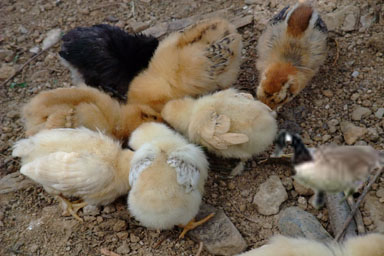

In [ ]:
# let's view a an image

boxes = list(data_dir.glob('*/*.*'))
Image.open(str(boxes[1]))

Let's look at the data distribution in our folder.

We can see there are two classes: Au & Tp. These both stand for the Pristine (Authentic) & Fake (Tampered) images.



In [ ]:
def get_data_distr(base_dir):
  label = []       #  Assign all label
  images_path = [] # Get all images path
  all_images = []  # Check all images name
  idx = 0          # index
  img_label = []   # Assign image label

  for directory in os.listdir(base_dir):
    if '.' != directory[0] and os.path.isdir(os.path.join(base_dir,directory)):
      label.append(directory)
      for img in os.listdir(os.path.join(base_dir,directory)):
          if len(re.findall('.png',img.lower())) != 0 or len(re.findall('.jpg',img.lower())) != 0 or len(re.findall('.tif',img.lower())) != 0:
              img_path = os.path.join(os.path.join(base_dir,directory),img)
              all_images.append(img)
              images_path.append(img_path)
              img_label.append(directory)
  # create dataframe
  data =pd.DataFrame({'image':images_path,'label':img_label})
  data_label = data['label'].value_counts()
  plt.figure()
  sns.barplot(x = data_label.index, y = data_label)
  print(f"Total Images class [0]:{data_label[0]}")
  print(f"Total Images class [1]:{data_label[1]}")

Total Images class [0]:1210
Total Images class [1]:793


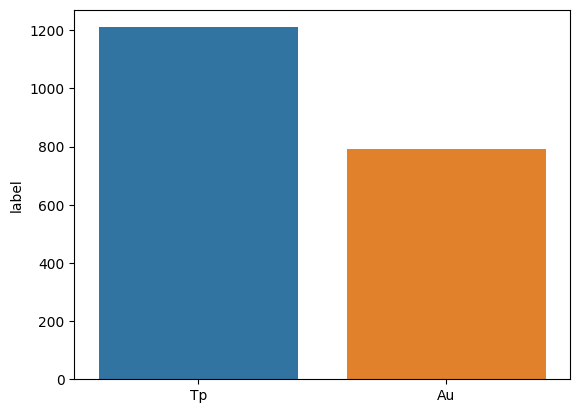

In [ ]:
get_data_distr(data_dir)

Let's view the ELA of an image in each of the classes at different qualities. We can notice there is some difference in the ELA representation of the different classes.

In [ ]:
def convert_to_ela_image(path, quality):
    '''
    Convert image to ELA format
    '''
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [ ]:
def view_ela(p):
  '''
  View ELA of image at different quality levels.
  '''
  orig = cv2.imread(p)
  orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
  init_val = 100
  columns = 3
  rows = 3

  fig=plt.figure(figsize=(15, 10))
  for i in range(1, columns*rows +1):
      quality=init_val - (i-1) * 3
      img = convert_to_ela_image(path=p, quality=quality)
      if i == 1:
          img = orig.copy()
      ax = fig.add_subplot(rows, columns, i)
      ax.title.set_text(f'q: {quality}')
      plt.imshow(img)
  plt.show()

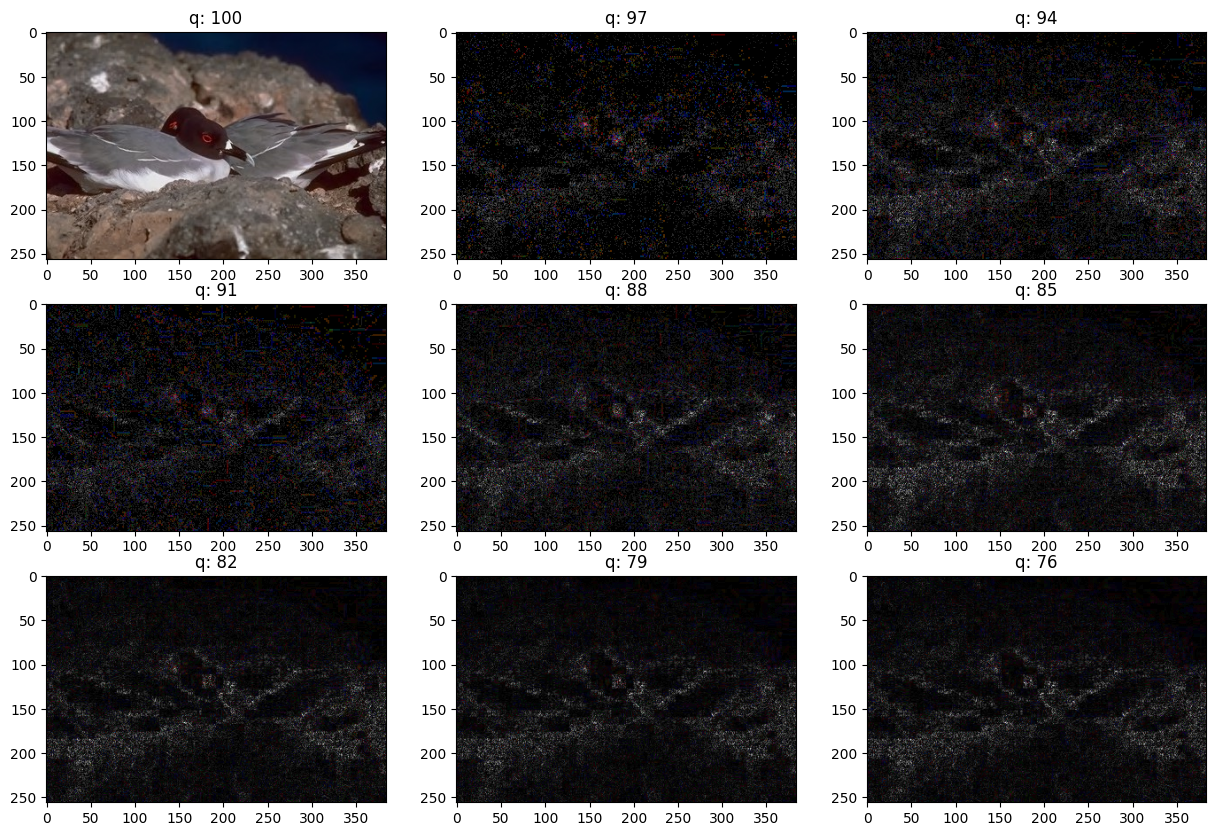

In [ ]:
pristine_image_path = '/content/drive/MyDrive/CASIA2.0_revised/Au/Au_ani_00008.jpg'
view_ela(pristine_image_path)

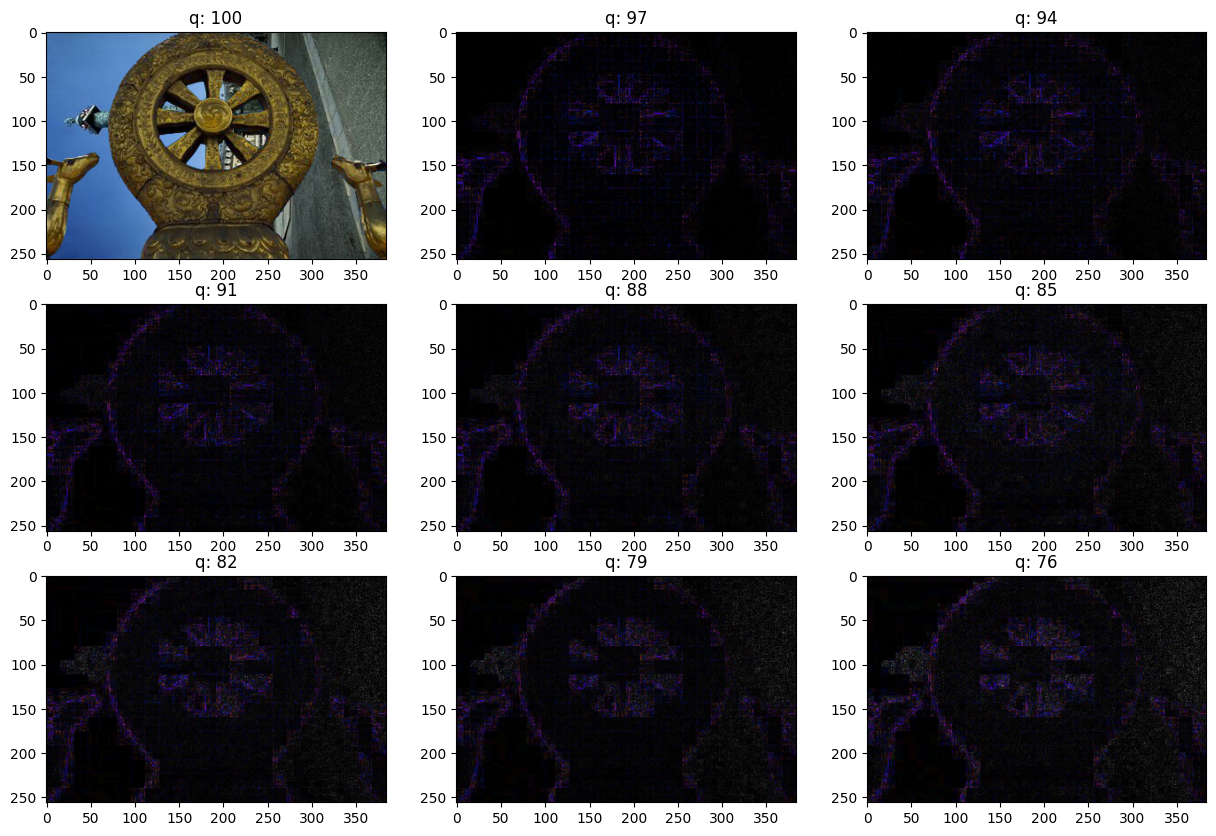

In [ ]:
fake_image_path = '/content/drive/MyDrive/CASIA2.0_revised/Tp/Tp_D_CNN_M_N_art00052_arc00030_11853.jpg'
view_ela(fake_image_path)

We now proceed to convert all images in out test set into their ELA format so they can be fed into the model

In [ ]:
def image_to_ela(path, quality, resave_path):
    ''' Gets images specified as path and resaves it at a new path resave_path at specified quality'''
    try:
        # Check if the file format is supported (JPEG or PNG)
        if path.endswith('jpg') or path.endswith('jpeg') or path.endswith('tif'):
            # Open the image and convert it to RGB mode
            image = Image.open(path).convert('RGB')

            # Resave the image with the specified quality
            image.save('resaved.jpg', 'JPEG', quality=quality)
            resaved = Image.open('resaved.jpg')

            # Calculate the ELA (Error Level Analysis) image by taking the difference between the original and resaved image
            ela_image = ImageChops.difference(image, resaved)

            # Get the minimum and maximum pixel values in the ELA image
            band_values = ela_image.getextrema()
            max_value = max([val[1] for val in band_values])

            # If the maximum value is 0, set it to 1 to avoid division by zero
            if max_value == 0:
                max_value = 1

            # Scale the pixel values of the ELA image to the range [0, 255]
            scale = 255.0 / max_value
            ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

            # Save the ELA image with the same filename in the specified resave path
-            ela_image.save(os.path.join(resave_path, os.path.basename(path)), 'JPEG')
    except Exception as e:
        print(f'Could not convert {path} to ELA: {str(e)}')

def preprocess_data(parent_path, files, resave_path):
    ''' Loops through a directory and applies the image_to_ela function to each image in the directory'''
    for file in files:
        image_to_ela(os.path.join(parent_path, file), 90, resave_path)

In [ ]:
# convert images to ELA

PRISTINE = '/content/drive/MyDrive/CASIA2.0_revised/Au'
FAKE = '/content/drive/MyDrive/CASIA2.0_revised/Tp'
PRISTINE_ELA = '/content/drive/MyDrive/CASSIA_ela/pristine'
FAKE_ELA = '/content/drive/MyDrive/CASSIA_ela/fake'

auth_files = os.listdir(PRISTINE)

# get list of all Tempered images
doc_files = os.listdir(FAKE)

# create the all_reals and all_docs where we save the real and doctored ELA images

if not os.path.exists(PRISTINE_ELA):
  os.makedirs(PRISTINE_ELA)
if not os.path.exists(FAKE_ELA):
  os.makedirs(FAKE_ELA)

# converting  validation real images to ela
parent_path_pristine = PRISTINE
preprocess_data(parent_path_pristine, auth_files, PRISTINE_ELA)

# converting training doctored images to ela
parent_path_fake = FAKE
preprocess_data(parent_path_fake, doc_files, FAKE_ELA)

print('There are ' + str(len(os.listdir(PRISTINE_ELA))) + ' converted Pristine Images')
print('There are ' + str(len(os.listdir(FAKE_ELA))) + ' converted Fake Images')

There are 793 converted Pristine Images
There are 1075 converted Fake Images


**CREATE TRAINING AND VALIDATION DATASET**

Now we shall create a dataset using the keras dataset functionality in tensorflow. As It's good practice to use a validation split when developing our model, we use 80% of the images for training and 20% for validation. This dataset will be passed to the CNN model

In [ ]:
# specify ela image path
path = '/content/drive/MyDrive/CASSIA_ela'
data_dir_ela = pathlib.Path(path)

In [ ]:
# Set some parameters
batch_size = 32
img_height = 160
img_width = 160
IMG_SIZE = (img_height, img_width)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_ela,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1443 files belonging to 2 classes.
Using 1155 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_ela,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1443 files belonging to 2 classes.
Using 288 files for validation.


We can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order. We then visualize the a sample of the dataset.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['fake', 'pristine']


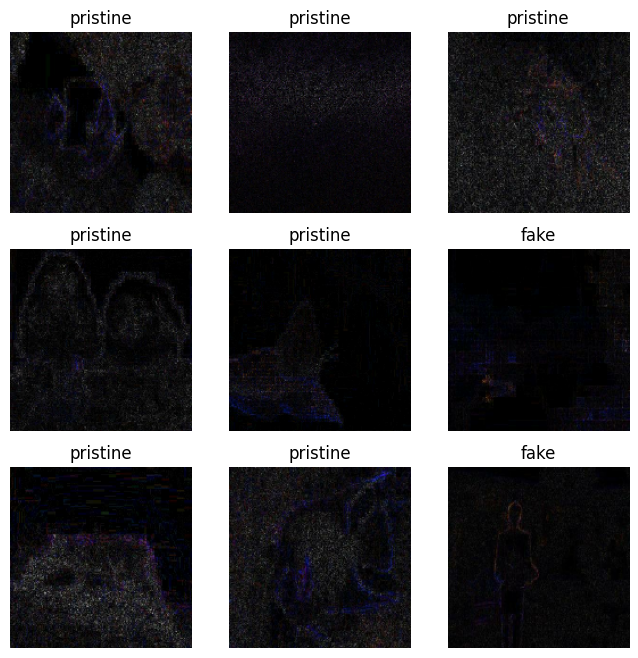

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

View image batch and label batch that will be served to our model for training

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 160, 160, 3)
(32,)


**CONFIGURE DATASET FOR PERFORMANCE**

In order to reduce the bottleneck, we use buffered prefetching, so we can yield data from disk without having I/O become blocking. We use the prefetch approach overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

We standardized our dataset so it can be optimized for the model.

In [ ]:
# standardize
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.3804699


**DATA AUGMENTATION**

In order to avoid overfitting, we augment the data so the model can be able to generalise more on the dataset. We augment by rotating or skewing the image slightly. A few of the augmented images are displayed below.

In [ ]:
# Augment data
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

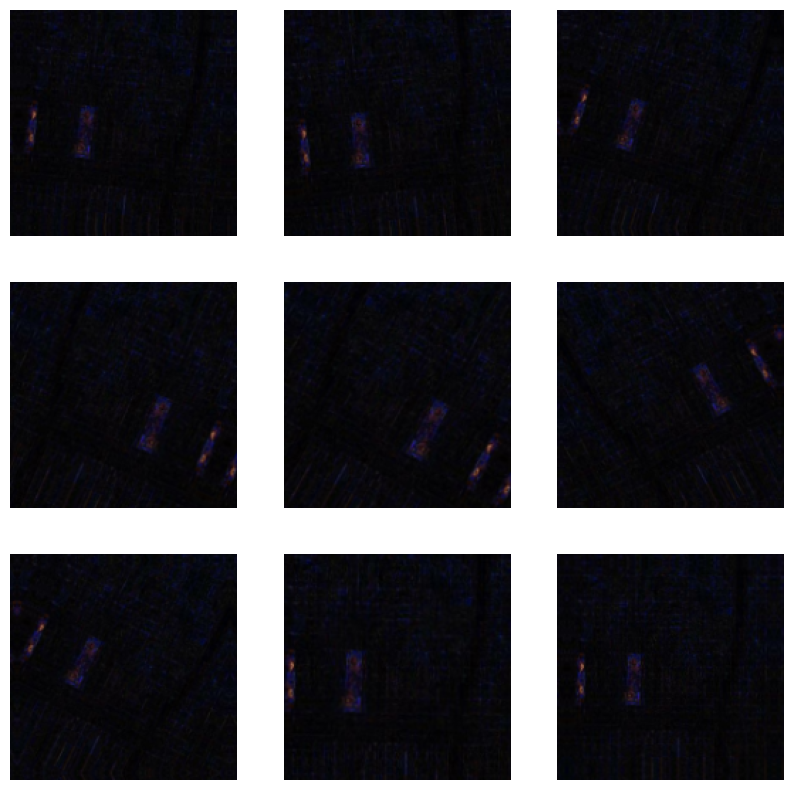

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### NETWORK ARCHITECTURE

For the CNN model, we try two approaches. First, we build a custome CNN model and train on the dataset to see the performance. Secondly, we use transfer learning on MobileNet V2 with its weights which has been trained on Imagenet dataset and compare the performance


**CUSTOM MODEL**
This model consists of the following layer:
1. A Rescaling layer is used to normalize pixel values of the input images. In this case, it divides the pixel values by 255, which scales them to the range [0, 1].
2. The first CONV layer which adds a 2D convolutional operation with 16 filters of size 3x3 to the model with a Rectified linear unit (ReLU) activation function element-wise to the output.
3. The Max Pooling layer which performs 2D max pooling on the input. It reduces the spatial dimensions of the feature maps while retaining the most important information.
4. Layers 4 - 7 consists of Conv2D and MaxPooling2D blocks as described earlier but with increasing filter sizes (32 and 64) to capture more complex features from the input images.
5. Next is a flatten layer flattens the 2D feature maps into a 1D vector. This is necessary to transition from convolutional layers to fully connected (dense) layers.
6. The final layers are 2 Dense laywers with the first one having 128 neurons and applies the ReLU activation function to capture high-level abstract features from the flattened feature maps, while the second and last layer has 2 neauraons corresponding to the image categories and produces raw logits for each class, which can be used for calculating probabilities and making predictions

In [ ]:
# Build custom model

num_classes = len(class_names)

modell = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Hyperparameters are set before the model is compiled. Adam optimizers are used, the loss parameter used is SparseCategoricalCrossentropy and metric to gauge the model on is accuracy.

We compiler and train the model on 15 epochs to see its performance. After which, we visualize the training and validation metrics

In [ ]:
modell.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs =15
history = modell.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/15
37/37 [==============================] - 46s 1s/step - loss: 0.5449 - accuracy: 0.7108 - val_loss: 0.7566 - val_accuracy: 0.5625
Epoch 2/15
37/37 [==============================] - 44s 1s/step - loss: 0.4288 - accuracy: 0.8078 - val_loss: 0.3838 - val_accuracy: 0.8299
Epoch 3/15
37/37 [==============================] - 41s 1s/step - loss: 0.3497 - accuracy: 0.8554 - val_loss: 0.3036 - val_accuracy: 0.8750
Epoch 4/15
37/37 [==============================] - 52s 1s/step - loss: 0.3266 - accuracy: 0.8693 - val_loss: 0.2917 - val_accuracy: 0.8819
Epoch 5/15
37/37 [==============================] - 46s 1s/step - loss: 0.2757 - accuracy: 0.8935 - val_loss: 0.2915 - val_accuracy: 0.8819
Epoch 6/15
37/37 [==============================] - 39s 1s/step - loss: 0.2842 - accuracy: 0.8788 - val_loss: 0.3367 - val_accuracy: 0.8507
Epoch 7/15
37/37 [==============================] - 51s 1s/step - loss: 0.2467 - accuracy: 0.9013 - val_loss: 0.4207 - val_accuracy: 0.8160
Epoch 8/15
37/37 [==

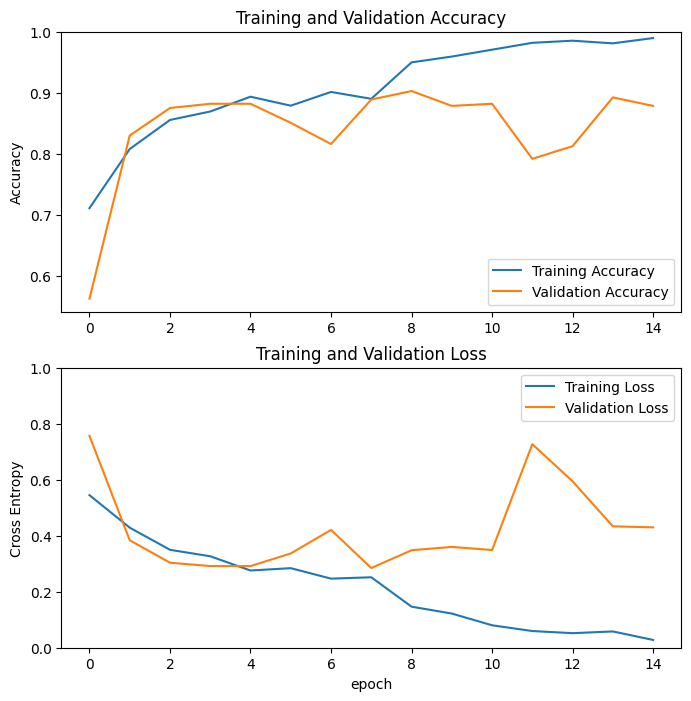

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

From this chart, we can see that the model is tending to overfit on the data becasue the training loss is getting to zero while the validation loss is increasing.
Let's view some metrics.

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = modell.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = predictions[:32]
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)


In [ ]:
loss, accuracy = modell.evaluate(val_ds)
print('Test accuracy :', accuracy)

9/9 [==============================] - 3s 282ms/step - loss: 0.4713 - accuracy: 0.8819
Test accuracy : 0.8819444179534912


In [ ]:
# Show performance metrics
print(classification_report(label_batch, predictions.numpy()))

              precision    recall  f1-score   support

           0       0.38      0.38      0.38        16
           1       0.38      0.38      0.38        16

    accuracy                           0.38        32
   macro avg       0.38      0.38      0.38        32
weighted avg       0.38      0.38      0.38        32



The accuracy, recall, precision and F1 score is shown below and we can see that though the accuracy is high, the precision, recall and F1 score are low. This means our model is not performing well.

**TRANSFER LEARNING ON MOBILE NET V2**

Let's explore our second approach which is to apply transfer learning on MobileNet V2 model which was trainied to classify 1000 images with its weigths.

The approach taken for this approach are as follows:
1. Load the pre-trained MobileNetV2 model with weights trained on ImageNet while excluding the final fully connected layers of the model so we can train it on our dataset.
2. Extract features of the downlaoded model which will be used as input for our final layers.
3. Freeze the layers of the base model so as to keep the pre-trained weights fixed to avoid losing the knowledge captured by the original model.
4. Add a layer to preprocess the input for the base model.  It performs a series of transformations on the images to make them suitable for input to the model. These transformations typically involve normalizing/rescaling pixel values and reshaping the images to match the expected input shape of the MobileNetV2 model.
5. Add a Global Average Pooling layer which is used to reduce the spatial dimensions of the extracted features to a single value per channel to further compress and represent the features before passing them to the final classification layers of our model.
6. Add a Dense layer of 1 neuron which the model will use to produce predictions based on the processed features.
7. Combine all layers together to create our model.
8. Hyperparameters setting and model compilation. Adam optimizer is used at a learning rate of 0.0001, Binary Cross Entropy is used for loss function beacuse of its performance with binary classification problems. Accuracy is used for metrics.
9. Model is trained on 25 epochs and we view the results.

In [ ]:
# set input image shape
IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)

# 1. Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#2. Feature extraction
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
#3. freeze base model and add layers to suit our use case
base_model.trainable = False

In [ ]:
# 4. preprocess input by normalizing/rescaling pixel
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# 5. Add a Global Average Pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
# 6. Add a Dense layer for final prediction
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
# 7. Combine all layers together
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# 8. Compile model with Hyperparameters

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
# train model
initial_epochs = 25
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/25
37/37 [==============================] - 100s 3s/step - loss: 0.8720 - accuracy: 0.5004 - val_loss: 0.8321 - val_accuracy: 0.4965
Epoch 2/25
37/37 [==============================] - 4s 94ms/step - loss: 0.8003 - accuracy: 0.4701 - val_loss: 0.7847 - val_accuracy: 0.5382
Epoch 3/25
37/37 [==============================] - 4s 80ms/step - loss: 0.7546 - accuracy: 0.5307 - val_loss: 0.7456 - val_accuracy: 0.5660
Epoch 4/25
37/37 [==============================] - 3s 74ms/step - loss: 0.7197 - accuracy: 0.5628 - val_loss: 0.7119 - val_accuracy: 0.5972
Epoch 5/25
37/37 [==============================] - 3s 74ms/step - loss: 0.6882 - accuracy: 0.5584 - val_loss: 0.6814 - val_accuracy: 0.6389
Epoch 6/25
37/37 [==============================] - 4s 94ms/step - loss: 0.6512 - accuracy: 0.6043 - val_loss: 0.6538 - val_accuracy: 0.6389
Epoch 7/25
37/37 [==============================] - 3s 74ms/step - loss: 0.6261 - accuracy: 0.6312 - val_loss: 0.6299 - val_accuracy: 0.6597
Epoch 8/25
37

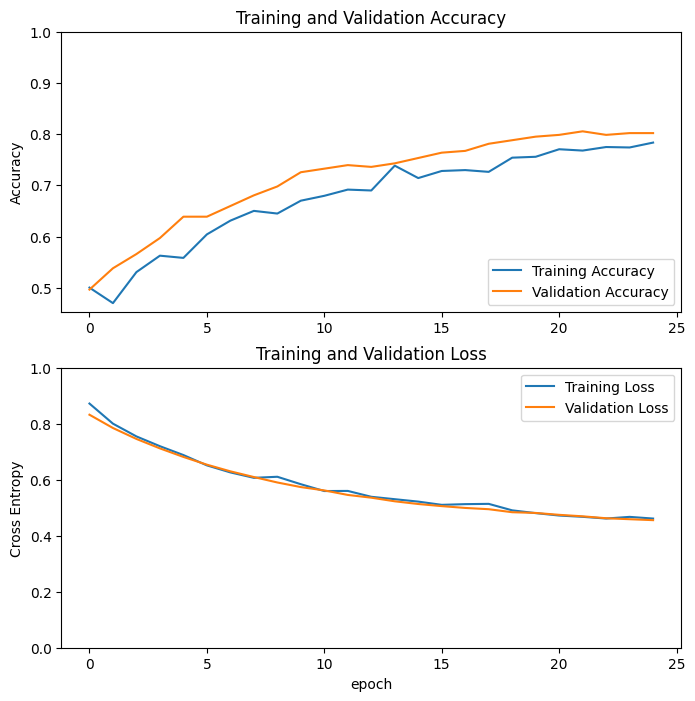

In [ ]:
# view accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

From the visualisation, we see that the training and Validation loss are reducing at a uniform rate. We can further fine tune the model and train on more epochs. To fine tune our mode, we train some layers of our base model. Out of 154 layers, we will train last 100 and leave the freeze the remaining layers. We compile the model with same Hyperparameters and then train on an additional 40 epochs.


In [ ]:
# Set trainable to true
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 25/55
37/37 [==============================] - 17s 105ms/step - loss: 0.4298 - accuracy: 0.7853 - val_loss: 0.3938 - val_accuracy: 0.8472
Epoch 26/55
37/37 [==============================] - 4s 105ms/step - loss: 0.3754 - accuracy: 0.8260 - val_loss: 0.3198 - val_accuracy: 0.8507
Epoch 27/55
37/37 [==============================] - 4s 97ms/step - loss: 0.3328 - accuracy: 0.8537 - val_loss: 0.3349 - val_accuracy: 0.8819
Epoch 28/55
37/37 [==============================] - 3s 79ms/step - loss: 0.3172 - accuracy: 0.8571 - val_loss: 0.3989 - val_accuracy: 0.8576
Epoch 29/55
37/37 [==============================] - 4s 103ms/step - loss: 0.3014 - accuracy: 0.8710 - val_loss: 0.5292 - val_accuracy: 0.7847
Epoch 30/55
37/37 [==============================] - 4s 78ms/step - loss: 0.3046 - accuracy: 0.8597 - val_loss: 0.2768 - val_accuracy: 0.9028
Epoch 31/55
37/37 [==============================] - 3s 81ms/step - loss: 0.2588 - accuracy: 0.8874 - val_loss: 0.3545 - val_accuracy: 0.8611
Ep

**VISUALIZE TRAINING**

We can see on the Visualisation how the model performed the moment we finetuned it.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

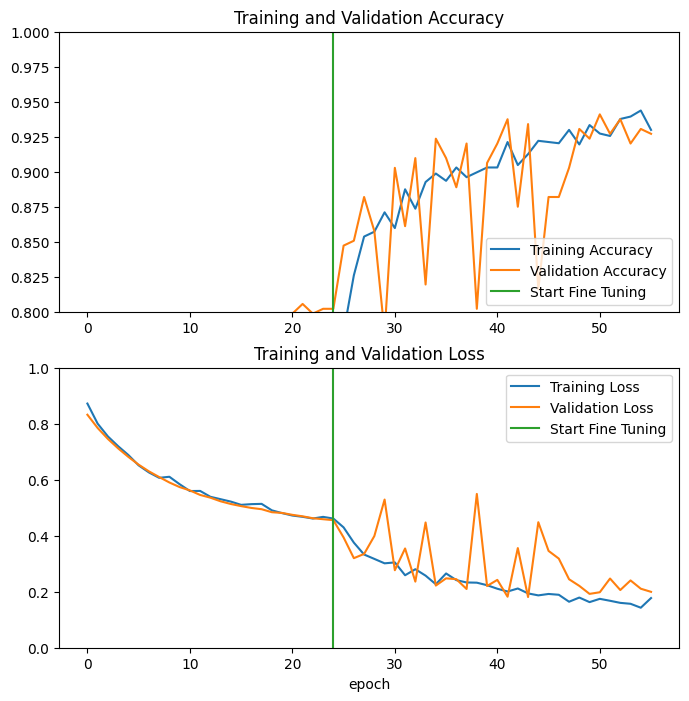

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
##### Evaluate and predict

**EVALUATE MODEL PERFORMANCE**

The accuracy shows some improvement at 92%, while the Precision, Recall, F1 score of both classes are much better.

Few predictions of the model with its actual labels are shown. The AU ROC is at 94%

Finally, we see the confusion matrix on out validation set which shows how well the model performed.

In [ ]:
# accuracy
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

9/9 [==============================] - 1s 32ms/step - loss: 0.1996 - accuracy: 0.9271
Test accuracy : 0.9270833134651184


Predictions:
 [1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1]
Labels:
 [1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1]


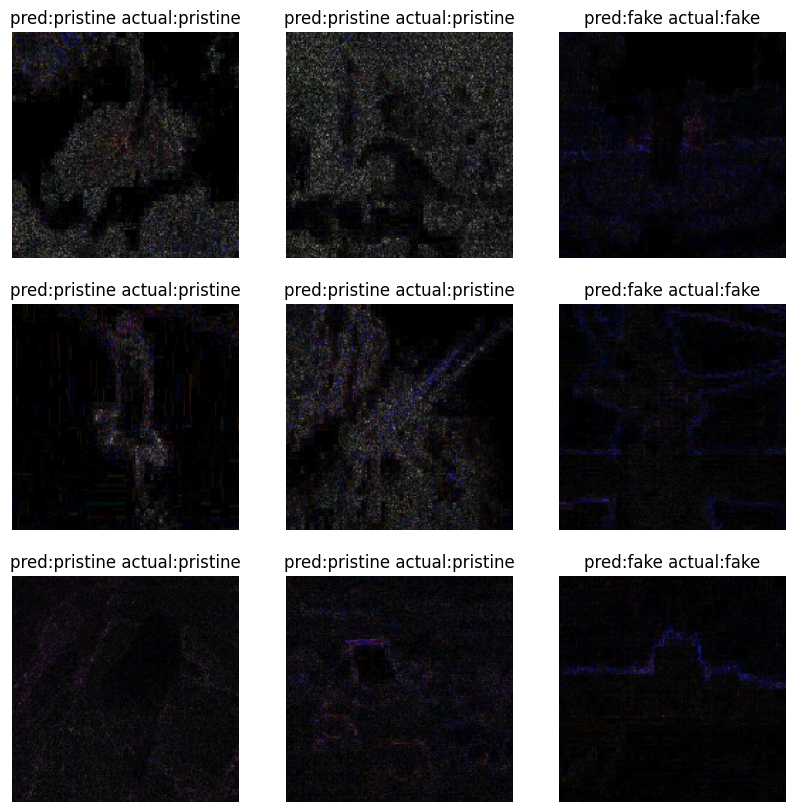

In [ ]:
# view Predicition

# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('pred:'+class_names[predictions[i]]+ ' actual:'+class_names[label_batch[i]])
  plt.axis("off")

In [ ]:
# Metrics
print(classification_report(label_batch, predictions.numpy()))


              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.95      0.95      0.95        19

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



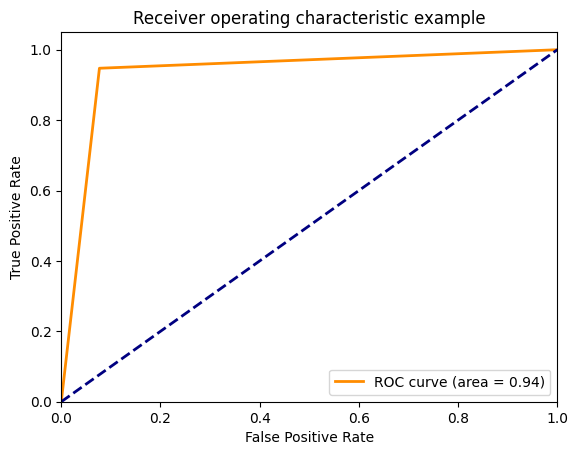

In [ ]:
# ROC CURVE
fpr, tpr, _ = roc_curve(label_batch, predictions.numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

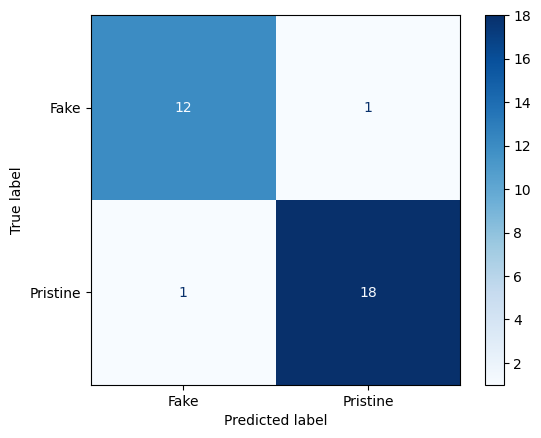

In [ ]:
# Confusion Matrix
cm = confusion_matrix(label_batch, predictions.numpy())
labels = ['Fake', 'Pristine']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

Save model for Inference

In [ ]:
# Save the entire model to a HDF5 file.
model.save('/content/drive/MyDrive/models/my_model.h5')

## INFERENCE

Inorder to perform inference on the model with new images, they must first be convered to ELA before passing through the model.

In [ ]:
# load the trained model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/models/my_model.h5')

In [ ]:
def convert_to_ela_image(path, quality):
    '''
    convert inference image to ela
    '''
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

def show_img_file(path):
      '''
      display inference image
      '''
      img_path = pathlib.Path(path)
      img = tf.keras.utils.load_img(img_path, target_size=(160, 160))
      plt.imshow(img)
      plt.axis("off")
      plt.show()

In [ ]:
def predict_img_file(path):
    # try:
        img_path = pathlib.Path(path)
        img = tf.keras.utils.load_img(img_path, target_size=(160, 160))
        img = convert_to_ela_image(path, 90)
        img = img. resize((160, 160))
        img_array = tf.keras.utils.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        predictions = loaded_model.predict_on_batch(img_batch).flatten()
        predictions = tf.nn.sigmoid(predictions)
        predictions = tf.where(predictions < 0.5, 0, 1)
        labels = ['Fake', 'Pristine']
        return  'This picture is {}'.format(labels[predictions.numpy()[0]])

Pristine prediction

In [ ]:

%%time
path = "/content/drive/MyDrive/Au_txt_30018.jpg"
predict_img_file(path)


CPU times: user 34.1 ms, sys: 889 µs, total: 35 ms
Wall time: 40.4 ms


'This picture is Pristine'

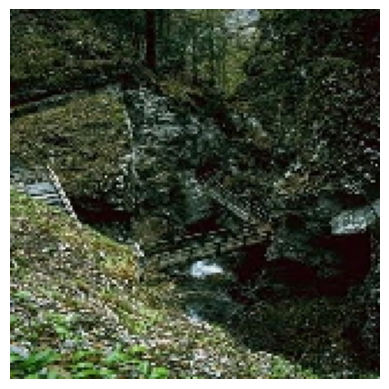

In [ ]:
show_img_file('/content/drive/MyDrive/Au_txt_30018.jpg')

Fake prediction

In [ ]:

%%time
path = "/content/drive/MyDrive/Tp_D_NRN_S_N_nat00097_ani00017_11412.jpg"
predict_img_file(path)


CPU times: user 32.1 ms, sys: 1.1 ms, total: 33.2 ms
Wall time: 71.7 ms


'This picture is Fake'

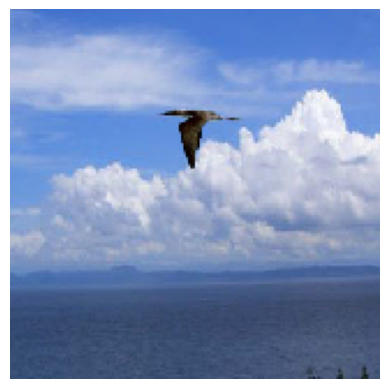

In [ ]:
show_img_file('/content/drive/MyDrive/Tp_D_NRN_S_N_nat00097_ani00017_11412.jpg')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

As seen, the predictions are less than a second.

**IMPROVEMENT**

Further work on improving the performance of this model will be to use the masked dataset which clearly showed the tampered region in an image to train the model further.